# Text classification with LSTM (RNN)

## Import Libraries

In [63]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
# import plotly.plotly as py
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
import matplotlib as mpl
from matplotlib import pyplot
import os
import jieba # 中文分词组件
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\idgca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import data

In [147]:
def read_data(rootdir, target_name, target_index):
    
    for root, subdirs, files in os.walk(rootdir):
        for file in files:
            path = root+'/'+file
            with open(path, encoding="utf8") as f:
                input_file = f.read()
                data.append(input_file)
                target_names.append(target_name)
                target.append(target_index)

data = []
target_names = []
target = []
read_data("data/classification_data_v3/中性", "中性", 0)
read_data("data/classification_data_v3/买入", "买入", 1)
read_data("data/classification_data_v3/卖出", "卖出", 2)

In [148]:
# combine data to single dataframe
df_raw = pd.DataFrame()
df_raw['data'] = data
df_raw['target_names'] = target_names
df_raw['target'] = target


In [149]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23769 entries, 0 to 23768
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data          23769 non-null  object
 1   target_names  23769 non-null  object
 2   target        23769 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 557.2+ KB


In [150]:
df_raw.target_names.value_counts()
df_raw.target.value_counts()

买入    17123
中性     6634
卖出       12
Name: target_names, dtype: int64

1    17123
0     6634
2       12
Name: target, dtype: int64

## Data exploration

In [151]:
df_raw['target_names'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Documents', 
                                                                title='Number of Documents in each category')

In [152]:
df = df_raw

In [153]:
# audit dataframe (check for nulls)
def table_info(data):
    tab_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
    tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.rename(index={0:'null values (%)'}))
    return tab_info

table_info(df)

,data,target_names,target
column type,object,object,int64
null values (nb),0,0,0
null values (%),0,0,0


## Data preprocessing

In [154]:
# print one sample
def print_data(index):
    example = df[df.index == index][['data', 'target_names']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])

print_data(100)

 
 
 
公司报告 | 年报点评报告 
  
中科创达（300496） 证券研究报告  2020年 02月 27日 
投资评级 
5G应用核心标的，报表继续验证高景气度！ 行业 计算机/计算机应用 
6个月评级 增持（维持评级） 
  
事件 当前价格 68.15元 
目标价格  元 
公司发布年报，2019 年营收 18.27 亿元，同比增长 24.74%，归母净利润  
2.38亿元，同比增长 44.63%。 
 基本数据 
19年业绩整体符合预期，维持快速增长 A股总股本(百万股) 402.52 
流通 A股股本(百万股) 283.19  
公司实现归母净利润 2.38亿元，同比增长约 45%，位于此前业绩预告中值
A股总市值(百万元) 27,431.40 
47%附近，符合市场预期。扣非后净利润高增主要与收入端高增有关，公  
司实现收入 18.27亿元，同比增长 24.74%，整体符合预期。结构看，手机/ 流通 A股市值(百万元) 19,299.49  
汽车/物联网业务同比增长 14%/72%/13%。公司布局新一代网联汽车业务， 每股净资产(元) 4.76 
市场渗透率提升，收入持续高速增长。公司整体毛利率上升 0.92个百分点， 资产负债率(%) 30.41 
考虑商业模式逐步变化，我们看好新业务汽车软件毛利率持续改善，投入 一 年内最高/最低(元) 79.90/25.73 
产出比提升。  
20年 Q1扣非业绩增长 43%略超预期  作者 
沈海兵 分析师 
公司发布 20Q1 业绩预告，业绩增速预计中值约 30%符合预期，扣非业绩 SAC执业证书编号：S1110517030001 
有望达 6000万，同比增长 43%略超预期。收入保持高增长，预计超 30%， shenhaibing@tfzq.com 
我们判断主要与物联网业务出货加速和汽车业务保持高速增长有关，业务 缪欣君 分析师 
面向全球，19年海外收入占比 56%，公司通过远程协同办公等方式发力海 SAC执业证书编号：S1110517080003 
外业务，受疫情影响有限。 miaoxinjun@tfzq.com  
潘暕 分析师 
20年基本面有望逐季加速，高度看好 SAC执业证书编号：S1110517070005 
 panjian@tfzq.com 
5G 应用三大赛道景气度推

In [155]:
df_backup = df

In [160]:
df = df_backup.sample(n = 2000) 
df = df.reset_index(drop=True)
df

,data,target_names,target
0,\n[table_research] \n公司点评●国防军工 2020 年 4 月...,买入,1
1,\n \n 2020年 4月 6日 \n \n安正时尚（603839.S...,买入,1
2,\n \n \n2020 年 08 月 29 日 \n \n白 \n色 投资评级：增持(...,中性,0
3,\n \n公司报告 | 年报点评报告 \n \n鸿路钢构（002541） 证券研究报告 ...,买入,1
4,证\n券\n 研\n公司究点评公 |司 完点美评世界 | 完美世界 \n西西部部证证券券 ...,买入,1
...,...,...,...
1995,\n2020 年 07 月 13 日 公司研究 评级：买入（维持） \n研 究所 \n证...,买入,1
1996,\n[Table_Message]2 020-08-12 \n \n公司点评报告 \n公 ...,中性,0
1997,\n \n[Table增_Ma持inInf o] \n——维持 亿纬锂能（300014...,中性,0
1998,\n[中Tab芯le_国Titl际e] -U（688981） \n公司研究/点评报告 \n...,买入,1


In [161]:
file_name = 'data/classification_data_v3/dict.txt'
jieba.load_userdict(file_name) # 自定义词汇
# remove special characters and punctuation
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.。%-]')
STOPWORDS = {"的","和","\n"," "} # set(stopwords.words('english'))
def clean_text(text):
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = re.compile('[，（）%％《》、:：]').sub(' ', text)
#     text = ''.join(re.findall(r'[\u4e00-\u9fa5]', text)) # only chinese words
    wordlist = jieba.lcut(text, cut_all=False) # partition
    text = ' '.join(word for word in wordlist if word not in STOPWORDS) # combine
    return text

df['data'] = df['data'].apply(clean_text)
# df['data'] = df['data'].str.replace('\d+', '') # remove all digits

In [162]:
def print_data(index):
    example = df[df.index == index][['data', 'target_names']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])

print_data(9)

Table _ StockInfo 2020 年 04 月 23 日 买入 维持 证券 研究 报告 • 2019 年报 及 2020 一 季报 点评 当前 价 85 92 元 中国 国旅 601888 休闲 服务 目标价 — — 元 6 个 月 业绩 稳健 离岛 可 期 疫情 不改 长期 成长 趋势 投资 要点 西南 证券 研究 发展 中心  T a 业 ble 绩 _ S 总 u 结 m ma 公 ry 司 发布 2019 年报 全年 实现 营收 479 7 亿元 同比 增长 2 0 实现 归母 净利润 46 3 亿元 同比 增长 49 6 实现 扣非 净利润 38 3 亿元 同 分 Ta 析 bl 师 e _ Au 朱 th 芸 or 比 增长 21 8 扣非 主要 受 处置 国旅总社 影响 其中 Q4 单 季度 实现 营收 123 8 执业 证号 S1250517070001 亿元 同比 下降 4 1 归母 净利润 4 3 亿元 同比 增长 11 3 同时 发布 2020 电话 010 57758600 年 一 季报 2020Q1 实现 营收 76 4 亿元 同比 下降 44 2 亏损 1 2 亿元 主 要 受 疫情 影响 邮箱 zhuz swsc com cn  2019 全年 内生 免税 稳健 增长 三亚 表现 亮眼 国旅总社 剥离 前 并表 收入 6 亿元 公司 全年 实现 商品销售 营收 469 7 亿元 同比 增长 36 8 分 板块 看 三亚 免 相 Ta 对 bl 指 e _ 数 Qu 表 o 现 te Pic 税城 下半年 受益 于 折扣 力度 加强 等 推动 因素 表现 亮眼 全年 实现 营收 104 7 亿 中国 国旅 沪 深 300 元 同比 增长 30 7 全年 接待 顾客 731 万人次 购物 人数 217 万人次 ； 上海 25 日上 实现 营收 151 5 亿元 同比 增长 45 首都机场 实现 营收 85 9 亿元 同比 增长 16 3 香港机场 实现 营收 24 0 亿元 同比 增长 14 5 白云机场 实现 营 18 收 19 2 亿元 同比 大幅 增长 117 5 其他 免税 营收 75 8 亿元 10  毛利率 受 汇率 影响 费用 端受 扣点 提升 拖累 减值 准备 等 影响 受 人民币 兑美 2 元 贬值 影响

In [164]:
def print_data(index):
    example = df[df.index == index][['data', 'target_names']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])

print_data(9)

Table _ StockInfo 2020 年 04 月 23 日 买入 维持 证券 研究 报告 • 2019 年报 及 2020 一 季报 点评 当前 价 85 92 元 中国 国旅 601888 休闲 服务 目标价 — — 元 6 个 月 业绩 稳健 离岛 可 期 疫情 不改 长期 成长 趋势 投资 要点 西南 证券 研究 发展 中心  T a 业 ble 绩 _ S 总 u 结 m ma 公 ry 司 发布 2019 年报 全年 实现 营收 479 7 亿元 同比 增长 2 0 实现 归母 净利润 46 3 亿元 同比 增长 49 6 实现 扣非 净利润 38 3 亿元 同 分 Ta 析 bl 师 e _ Au 朱 th 芸 or 比 增长 21 8 扣非 主要 受 处置 国旅总社 影响 其中 Q4 单 季度 实现 营收 123 8 执业 证号 S1250517070001 亿元 同比 下降 4 1 归母 净利润 4 3 亿元 同比 增长 11 3 同时 发布 2020 电话 010 57758600 年 一 季报 2020Q1 实现 营收 76 4 亿元 同比 下降 44 2 亏损 1 2 亿元 主 要 受 疫情 影响 邮箱 zhuz swsc com cn  2019 全年 内生 免税 稳健 增长 三亚 表现 亮眼 国旅总社 剥离 前 并表 收入 6 亿元 公司 全年 实现 商品销售 营收 469 7 亿元 同比 增长 36 8 分 板块 看 三亚 免 相 Ta 对 bl 指 e _ 数 Qu 表 o 现 te Pic 税城 下半年 受益 于 折扣 力度 加强 等 推动 因素 表现 亮眼 全年 实现 营收 104 7 亿 中国 国旅 沪 深 300 元 同比 增长 30 7 全年 接待 顾客 731 万人次 购物 人数 217 万人次 ； 上海 25 日上 实现 营收 151 5 亿元 同比 增长 45 首都机场 实现 营收 85 9 亿元 同比 增长 16 3 香港机场 实现 营收 24 0 亿元 同比 增长 14 5 白云机场 实现 营 18 收 19 2 亿元 同比 大幅 增长 117 5 其他 免税 营收 75 8 亿元 10  毛利率 受 汇率 影响 费用 端受 扣点 提升 拖累 减值 准备 等 影响 受 人民币 兑美 2 元 贬值 影响

## jieba library functions

In [85]:
wordlist = jieba.lcut(temp)
text = nltk.Text(wordlist)
print(text)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\idgca\AppData\Local\Temp\jieba.cache
Loading model cost 0.718 seconds.
Prefix dict has been built successfully.


<Text: 公司 报告 年报 点评 报告 中科 创达 证券...>


In [88]:
# 搜索上下文
text.concordance(word='报告',width=20,lines=10)

Displaying 10 of 33 matches:
公司 报告 年报 点评 报告
报告 年报 点评 报告 中科 创达 证券
创达 证券 研究 报告 年月日 投资 评
贝格 数据 相关 报告 中科 创达 季报
免责 申明 公司 报告 年报 点评 报告
报告 年报 点评 报告 财务 预测 摘要
免责 申明 公司 报告 年报 点评 报告
报告 年报 点评 报告 分析师 声明 本
分析师 声明 本 报告 署名 分析师 在
 胜任 能力 本 报告 所 表述 的 所


In [92]:
# 搜索共同上下文
text.common_contexts(['报告','公司'])
# 统计词频
text.count(word='报告')

No common contexts were found


33

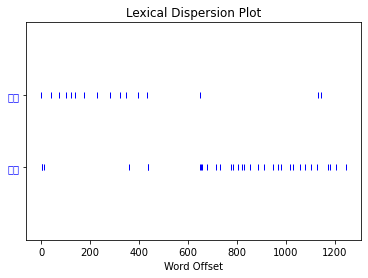

In [94]:
# 离散图
words=['公司','报告']
text.dispersion_plot(words)

In [97]:
# 计算相似度
text.similar(word='报告',num=10)

from nltk.text import ContextIndex
contentindex = ContextIndex(wordlist)
similarity_scores = contentindex.word_similarity_dict(word='报告')
for key,value in similarity_scores.items():
    if value>0.02:
        print(key,value)

发布
报告 1.0
发布 0.08333333333333333


## Tokenize documents

In [166]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 3000
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['data'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 110801 unique tokens.


## Save processed data to csv

In [134]:
# df.to_csv(r'data/classification_data_v3/cleaned.csv',header=True,index=None)

In [167]:
def count_text(text):
    return len(text.split(' '))
    
df['word_count'] = df.data.apply(count_text)
df['word_count']

0       2412
1       4086
2       2348
3       3035
4       2236
        ... 
1995    7543
1996    2056
1997    2600
1998    2269
1999    2578
Name: word_count, Length: 2000, dtype: int64

In [168]:
np.mean(df['word_count']) # each document has average 2500 words after processing 

3908.149

## Get train test datasets

In [169]:
X = tokenizer.texts_to_sequences(df['data'].values)


In [170]:
MAX_SEQUENCE_LENGTH = 1000
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2000, 1000)


In [171]:
Y = pd.get_dummies(df['target']).values
Y_single = df['target']
print('Shape of label tensor:', Y.shape)
print('Shape of label tensor:', Y_single.shape)

Shape of label tensor: (2000, 2)
Shape of label tensor: (2000,)



## Train test split

In [172]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1600, 1000) (1600, 2)
(400, 1000) (400, 2)


## LSTM

In [173]:
def create_model(activation='softmax',
                units=100,
                dropout=0.2,
                recurrent_dropout=0.2,
                loss='categorical_crossentropy',
                optimizer='adam',
                dense_units=2
                ):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    # units: Positive integer, dimensionality of the output space.
    # dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs
    # recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state
    model.add(LSTM(units, dropout=dropout, recurrent_dropout=recurrent_dropout))
    # units: Positive integer, dimensionality of the output space
    # (None, 3)
    model.add(Dense(dense_units, activation=activation))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

epochs = 3
batch_size = 72

clf = KerasRegressor(build_fn=create_model, verbose=0, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

pipeline = Pipeline([
    ('clf',clf)
])

history = pipeline.fit(X_train, Y_train)

C:\Users\idgca\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



KeyboardInterrupt: 

In [45]:
predicted = pipeline.predict(X_test)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(predicted[0],predicted[1]))
predicted

array([[0.5278084 , 0.47219163],
       [0.53196156, 0.46803844],
       [0.5298273 , 0.4701727 ],
       [0.52459806, 0.475402  ],
       [0.53196156, 0.46803844],
       [0.52833575, 0.47166416],
       [0.52936363, 0.4706364 ],
       [0.53196156, 0.4680384 ],
       [0.5267971 , 0.47320285],
       [0.5391728 , 0.46082723],
       [0.52936363, 0.4706364 ],
       [0.5391728 , 0.46082723],
       [0.53098667, 0.46901327],
       [0.53098667, 0.46901327],
       [0.5291094 , 0.47089052],
       [0.53196156, 0.4680384 ],
       [0.53610355, 0.4638965 ],
       [0.51962286, 0.48037708],
       [0.53196156, 0.46803844],
       [0.5391728 , 0.46082723]], dtype=float32)

In [46]:
np.mean(predicted == Y_test)

0.0

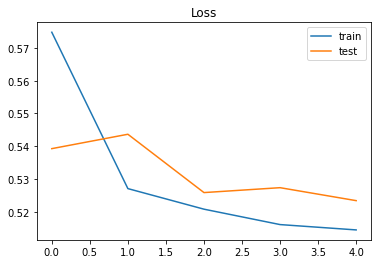

In [155]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

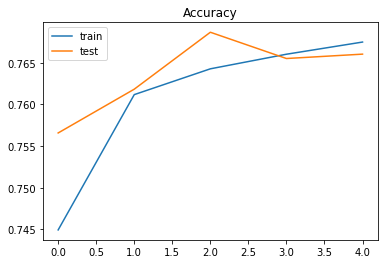

In [162]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [160]:
history.history


{'val_loss': [0.5392549102489379,
  0.5436472492889902,
  0.5258472341844336,
  0.527341907144721,
  0.5233879128841196],
 'val_accuracy': [0.7565720081329346,
  0.761829674243927,
  0.768664538860321,
  0.7655099630355835,
  0.7660357356071472],
 'loss': [0.5747780097204527,
  0.5270597410879122,
  0.5207833287097748,
  0.5160820137149704,
  0.5144538231555816],
 'accuracy': [0.74493074, 0.7611757, 0.76427275, 0.76602584, 0.7674867]}

In [210]:
pred = model.predict((X_test)) # [28:29,:]
pred

array([[2.7217430e-01, 7.2757405e-01, 2.5159252e-04],
       [2.7305761e-01, 7.2667521e-01, 2.6714511e-04],
       [1.8111259e-01, 8.1873506e-01, 1.5236292e-04],
       ...,
       [1.7219770e-01, 8.2754946e-01, 2.5281697e-04],
       [1.7943431e-01, 8.2046747e-01, 9.8176388e-05],
       [1.7481382e-01, 8.2509303e-01, 9.3145696e-05]], dtype=float32)

## Naive base

In [214]:
# pipeline
text_clf_nb = Pipeline([
#                         ('vect', CountVectorizer()), # attribute stop_words ("then, the, etc.")
#                      ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=0.01)), # FitPrior=False, a uniform prior will be used
                    ])

In [217]:
X_train, X_test, Y_single_train, Y_single_test = train_test_split(X,Y_single, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_single_train.shape)
print(X_test.shape,Y_single_test.shape)

(19015, 1000) (19015,)
(4754, 1000) (4754,)


In [219]:
text_clf_nb = text_clf_nb.fit(X_train, Y_single_train)

In [221]:
predicted = text_clf_nb.predict(X_test)
np.mean(predicted == Y_single_test)

0.652923853596971